# Credit Card Lead Prediction

`Problem Statement`:Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

- Customer details (gender, age, region etc.)
- Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

## 1.Data Understanding and cleaning 

In [1]:
#Importing necessary libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading the train data set
df1 = pd.read_csv('train_s3TEQDk.csv')
df1.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [3]:
#Let's cross-check if there are any duplicate values in ID column
sum(df1['ID'].duplicated())

0

So, the values in `ID` column are unique and we can exclude this for our further analyses.

In [4]:
#Copying the above dataframe excluding the 'ID' column to a new variable
df2 = df1.drop('ID',axis=1)
#Check
df2.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [5]:
#Checking the info w.r.t. each column
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Gender               245725 non-null  object
 1   Age                  245725 non-null  int64 
 2   Region_Code          245725 non-null  object
 3   Occupation           245725 non-null  object
 4   Channel_Code         245725 non-null  object
 5   Vintage              245725 non-null  int64 
 6   Credit_Product       216400 non-null  object
 7   Avg_Account_Balance  245725 non-null  int64 
 8   Is_Active            245725 non-null  object
 9   Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 18.7+ MB


There are missing values in `Credit_Product` column.

In [6]:
#Checking mising value % 
(df2['Credit_Product'].isna().sum())/len(df2)*100

11.9340726421813

In [7]:
#checking the value_counts % for the 'Credit_Product' column
df2['Credit_Product'].value_counts(normalize=True)*100

No     66.70841
Yes    33.29159
Name: Credit_Product, dtype: float64

In [8]:
df2['Credit_Product'].mode()[0]

'No'

From the above analyses it is evident that for about 12% of the customers,there's no information about `Credit_Product`. So, let's impute those missing values with a value "Not Known".

In [9]:
#Missing value imputation
df2['Credit_Product'].fillna("Not Known",inplace=True)
#Cross-check
df2['Credit_Product'].isna().sum()

0

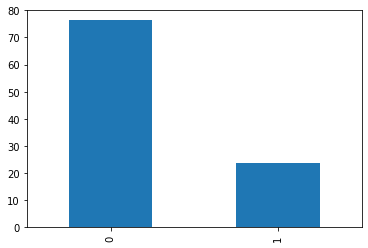

In [10]:
#Visualizing target variable 'Is_Lead'
(df2['Is_Lead'].value_counts(normalize=True)*100).plot(kind='bar')

From the above, it is evident that there's a high class imbalance between 'Not a lead' and 'lead' values.

### Resolving Class imbalance through resampling

In [11]:
from sklearn.utils import resample

# separate minority and majority classes
not_lead = df2[df2.Is_Lead==0]
lead = df2[df2.Is_Lead==1]

In [12]:
# upsample minority
lead_upsampled = resample(lead,
                          replace=True, # sample with replacement
                          n_samples=len(not_lead), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_lead, lead_upsampled])

# check new class counts
upsampled.Is_Lead.value_counts()

1    187437
0    187437
Name: Is_Lead, dtype: int64

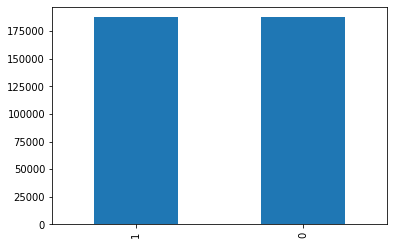

In [13]:
#Visualizing
upsampled.Is_Lead.value_counts().plot(kind='bar')

In [14]:
upsampled

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...
221846,Female,53,RG268,Salaried,X1,33,Yes,1501430,Yes,1
47581,Male,44,RG272,Other,X2,19,Not Known,695339,Yes,1
89022,Female,53,RG280,Other,X3,69,Not Known,659988,No,1
83046,Male,51,RG268,Self_Employed,X2,109,Not Known,2666876,Yes,1


In [15]:
df2 = upsampled
print(df2.shape)

(374874, 10)


In [16]:
df2.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


## 2. Data Preparation for modelling 

In [17]:
cat = [i for i in df2.columns if df2[i].dtype == 'O']
for i in cat:
    print(df2[i].value_counts())
    print('********************************************')

Male      212695
Female    162179
Name: Gender, dtype: int64
********************************************
RG268    59976
RG283    49487
RG254    39386
RG284    32030
RG280    19508
RG277    19503
RG269    11712
RG261    10493
RG270    10109
RG251     8947
RG257     8692
RG282     8307
RG272     7688
RG281     7534
RG274     7135
RG273     6869
RG279     5946
RG252     5642
RG263     5547
RG275     4508
RG276     4461
RG260     4426
RG259     3711
RG256     3685
RG264     3614
RG250     3388
RG255     2940
RG258     2935
RG253     2893
RG278     2696
RG262     2548
RG265     2375
RG271     2096
RG266     2082
RG267     2005
Name: Region_Code, dtype: int64
********************************************
Self_Employed    162571
Other            108496
Salaried          97296
Entrepreneur       6511
Name: Occupation, dtype: int64
********************************************
X1    124713
X3    124582
X2    117083
X4      8496
Name: Channel_Code, dtype: int64
***********************************

### Using Label Encoding  

In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
#Let's convert these categorical columns into numerical
df2['Gender']=label_encoder.fit_transform(df2['Gender'])
df2['Credit_Product']=label_encoder.fit_transform(df2['Credit_Product'])
df2['Is_Active'] = label_encoder.fit_transform(df2['Is_Active'])
df2['Occupation'] = label_encoder.fit_transform(df2['Occupation'])
df2['Region_Code'] = label_encoder.fit_transform(df2['Region_Code'])
df2['Channel_Code'] = label_encoder.fit_transform(df2['Channel_Code'])

#Cross-check
df2.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,0,73,18,1,2,43,0,1045696,0,0
1,0,30,27,2,0,32,0,581988,0,0
2,0,56,18,3,2,26,0,1484315,1,0
3,1,34,20,2,0,19,0,470454,0,0
4,0,30,32,2,0,33,0,886787,0,0


`Data Dictionary for Region Code`
 - Region_Code	Index
- RG250	0
- RG251	1
- RG252	2
- RG253	3
- RG254	4
- RG255	5
- RG256	6
- RG257	7
- RG258	8
- RG259	9
- RG260	10
- RG261	11
- RG262	12
- RG263	13
- RG264	14
- RG265	15
- RG266	16
- RG267	17
- RG268	18
- RG269	19
- RG270	20
- RG271	21
- RG272	22
- RG273	23
- RG274	24
- RG275	25
- RG276	26
- RG277	27
- RG278	28
- RG279	29
- RG280	30
- RG281	31
- RG282	32
- RG283	33
- RG284	34

`Data Dictionary for Occupation`
- Occupation	Index
- Entrepreneur	0
- Other	1
- Salaried	2
- Self_Employed	3

`Data Dictionary for Channel Code`
- Channel_Code	Index
- X1	0
- X2	1
- X3	2
- X4	3

In [19]:
# #Dividing the datasets into X (containing predictor variables) and y(target variable)
X = df2.drop('Is_Lead',axis=1)
y = df2['Is_Lead']

In [20]:
#Importing train_test_split to divide the X,y into train and validation sets respectively
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 4,shuffle = True)

In [21]:
X_train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
4952,1,39,31,3,1,69,2,527155,0
39135,1,54,30,3,1,85,1,190949,1
121477,0,32,4,2,0,19,1,510165,1
26063,0,32,33,2,0,26,0,2831793,0
116529,1,68,34,1,1,91,2,747128,1


In [22]:
y_train.head()

4952      1
39135     1
121477    1
26063     0
116529    1
Name: Is_Lead, dtype: int64

In [23]:
X_val.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
143492,1,52,32,1,1,93,1,1866419,1
119950,1,43,34,3,1,32,0,1803006,1
226340,0,46,27,3,2,93,1,1204588,0
18511,0,31,15,1,0,33,2,839510,0
101105,0,30,4,2,0,25,0,1361824,0


In [24]:
y_val.head()

143492    1
119950    0
226340    1
18511     0
101105    0
Name: Is_Lead, dtype: int64

In [25]:
# print shapes of train and test sets
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape)

(262411, 9) (262411,) (112463, 9) (112463,)


### Feature Scaling 

In [26]:
#Scaling all the columns except those which are binary
cols = ['Age','Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Avg_Account_Balance']
cols

['Age',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Vintage',
 'Credit_Product',
 'Avg_Account_Balance']

In [27]:
#Let's do feature scaling using the MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()
# X_train[['Age','Vintage','Avg_Account_Balance']] = scaler.fit_transform(X_train[['Age','Vintage','Avg_Account_Balance']])
X_train[cols] = scaler.fit_transform(X_train[cols])
#Cross-check
X_train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
4952,1,0.258065,0.911765,1.000000,0.333333,0.484375,1.0,0.049013,0
39135,1,0.500000,0.882353,1.000000,0.333333,0.609375,0.5,0.016470,1
121477,0,0.145161,0.117647,0.666667,0.000000,0.093750,0.5,0.047369,1
26063,0,0.145161,0.970588,0.666667,0.000000,0.148438,0.0,0.272088,0
116529,1,0.725806,1.000000,0.333333,0.333333,0.656250,1.0,0.070305,1


In [28]:
#Transforming validation data as well
# X_val[['Age','Vintage','Avg_Account_Balance']] = scaler.transform(X_val[['Age','Vintage','Avg_Account_Balance']])
X_val[cols] = scaler.transform(X_val[cols])
#Cross-Check
X_val.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
143492,1,0.467742,0.941176,0.333333,0.333333,0.671875,0.5,0.178646,1
119950,1,0.322581,1.000000,1.000000,0.333333,0.195312,0.0,0.172508,1
226340,0,0.370968,0.794118,1.000000,0.666667,0.671875,0.5,0.114585,0
18511,0,0.129032,0.441176,0.333333,0.000000,0.203125,1.0,0.079247,0
101105,0,0.112903,0.117647,0.666667,0.000000,0.140625,0.0,0.129804,0


In [29]:
print(X_train.shape)
print(X_val.shape)

(262411, 9)
(112463, 9)


## 3. Modelling 

### A) Logistic Regression 

In [30]:
#Using logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

model = logreg.fit(X_train,y_train)


In [31]:
#Predictions
y_train_pred = model.predict(X_train)
y_train_pred

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [32]:
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy_score(y_train,y_train_pred)

0.7107476439630961

In [33]:
roc_auc_score(y_train,y_train_pred)

0.7107536287979708

In [34]:
#final
final = pd.DataFrame({'Converted': y_train,'Predicted':y_train_pred})
final

,Converted,Predicted
4952,1,1
39135,1,1
121477,1,0
26063,0,0
116529,1,1
...,...,...
141113,0,0
124150,0,1
151066,0,0
169756,0,0


In [35]:
from sklearn.metrics import precision_recall_curve

In [36]:
p, r, thresholds = precision_recall_curve(final.Converted, final.Predicted)

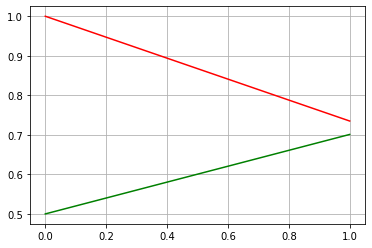

In [37]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.grid(True)
plt.show()

In [38]:
from sklearn.metrics import precision_score, recall_score 
print('The precision score is {0} and the recall score is {1}'.format(precision_score(y_train,y_train_pred),recall_score(y_train,y_train_pred)))

The precision score is 0.7009350551144461 and the recall score is 0.7349149596334612


In [39]:
#Predictions on validation data
y_val_pred = model.predict(X_val)
y_val_pred

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [40]:
accuracy_score(y_val,y_val_pred)

0.7103758569485075

In [41]:
roc_auc_score(y_val,y_val_pred)

0.7103626758377997

In [42]:
# #Just for testing
# a = np.array([1,29,254,3,1,25,1,742366,0]).reshape(-1,9)

In [43]:
# a1 = scaler.transform(a)
# a1

ValueError: X has 9 features, but MinMaxScaler is expecting 7 features as input.

In [ ]:
# b = model.predict(a1)
# print(b)

In [ ]:
# b = model.predict(a)
# print(b)

In [ ]:
# df2.iloc[53824][:]

In [ ]:
# final[final.Predicted==0]

In [ ]:
# df2.iloc[139857][:]

### B) Random Forest classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier
# classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)

In [45]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)

In [46]:
rf.estimators_[0]

DecisionTreeClassifier(max_depth=3, max_features='auto',
                       random_state=1608637542)

In [47]:
from sklearn.metrics import confusion_matrix
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, rf.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, rf.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_val, rf.predict(X_val)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_val, rf.predict(X_val)))

In [48]:
evaluate_model(rf)

Train Accuracy : 0.7810152775607729
Train Confusion Matrix:
[[104460  26778]
 [ 30686 100487]]
--------------------------------------------------
Test Accuracy : 0.7785760650169389
Test Confusion Matrix:
[[44610 11589]
 [13313 42951]]


In [49]:
# # Create the parameter grid based on the results of random search 
# params = {
#     'max_depth': [1, 2, 5, 10],
#     'min_samples_leaf': [5, 10, 20, 50],
#     'max_features': [2,3,4,5,6],
#     'n_estimators': [10, 30, 50]
# }

In [50]:
# # Instantiate the grid search model
# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=params, 
#                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [51]:
# %%time
# grid_search.fit(X_train, y_train)

In [52]:
# grid_search.best_estimator_

In [53]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, dt_best.predict(X_test)))

### C) AdaBoost Classifier 

In [54]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators = 100,random_state=100)

In [55]:
abc.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100, random_state=100)

In [56]:
y_train_pred = abc.predict(X_train)
score = accuracy_score(y_train, y_train_pred)
print(score)

0.7967730011318123


In [57]:
y_val_pred = abc.predict(X_val)
val_score = accuracy_score(y_val,y_val_pred)
print(val_score)

0.7954527266745507


In [ ]:
#Just for testing
a = np.array([1,2,3,4,5,6,7,8,9]).reshape(3,3)
a

In [ ]:
a[0][0].max()

In [ ]:
a

In [ ]:
a[1][:].max()

In [ ]:
a[1][:].min()

In [ ]:
a[0:][1]

In [ ]:
b = pd.DataFrame(a)

In [ ]:
b

In [ ]:
#Test
df2.iloc[177938][:]

In [ ]:
#Test 2
df2

### D) Gradient Boosting 

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
#Fitting Model
gbm.fit(X_train, y_train)

GradientBoostingClassifier()

In [59]:
#predictions on train data
y_train_pred = gbm.predict(X_train)
#Calculating accuracy
print('The train accuracy is {0}'.format(accuracy_score(y_train,y_train_pred)))

The train accuracy is 0.8050920121488809


In [60]:
#Predictions on validation data
y_val_pred = gbm.predict(X_val)
#Calculating accuracy
print('The validation accuracy is {0}'.format(accuracy_score(y_val,y_val_pred)))

The validation accuracy is 0.803677653983977


### E) XGBoost 

In [61]:
import xgboost as xgb

In [62]:
#Fitting model
xgclf = xgb.XGBClassifier()

xgclf.fit(X_train, y_train)

[12:00:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
#Predictions on train data
y_train_pred = xgclf.predict(X_train)
#Calculating accuracy
print('The train accuracy is {0}'.format(accuracy_score(y_train,y_train_pred)))

The train accuracy is 0.8211431685409529


In [64]:
#Predictions on validation data
y_val_pred = xgclf.predict(X_val)
#Calculating accuracy
print('The validation accuracy is {0}'.format(accuracy_score(y_val,y_val_pred)))

The validation accuracy is 0.8117780959070984


### Practice 

In [73]:
#Testing
d = {'I': 1, 'Love': 4, 'You': 3}
l1 = ['I','Love','You']

In [74]:
l2 = list(map(d,l1))
print(l2)

TypeError: 'dict' object is not callable

In [75]:
d1 = {1:0,2:1,3:2,4:3}
d1.get(1)

0

In [76]:
key = [i for i in range(250,285)]
val = [i for i in range(len(key))]

In [77]:
d2 = {k:v for (k,v) in zip(key, val)}
print(d2)

{250: 0, 251: 1, 252: 2, 253: 3, 254: 4, 255: 5, 256: 6, 257: 7, 258: 8, 259: 9, 260: 10, 261: 11, 262: 12, 263: 13, 264: 14, 265: 15, 266: 16, 267: 17, 268: 18, 269: 19, 270: 20, 271: 21, 272: 22, 273: 23, 274: 24, 275: 25, 276: 26, 277: 27, 278: 28, 279: 29, 280: 30, 281: 31, 282: 32, 283: 33, 284: 34}


In [78]:
a = np.array([1,2,3,4,5,6]).reshape(-1,6)
a

array([[1, 2, 3, 4, 5, 6]])

In [79]:
a[1:6]

array([], shape=(0, 6), dtype=int32)

In [80]:
print(list(a))

[array([1, 2, 3, 4, 5, 6])]


In [81]:
key[1:8]

[251, 252, 253, 254, 255, 256, 257]

In [82]:
a = np.array(key).reshape(-1,len(key))
df4 = pd.DataFrame(a)
df4

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,250,251,252,253,254,255,256,257,258,259,...,275,276,277,278,279,280,281,282,283,284


In [83]:
arr = np.array(df4).reshape(-1,35)
arr

array([[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
        263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
        276, 277, 278, 279, 280, 281, 282, 283, 284]])

In [ ]:
df4.iloc[:,1:4]

In [65]:
l = [i for i in range(10)]

In [66]:
f = pd.DataFrame(l)

In [67]:
f

,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [68]:
l = ['Sriram',1996]

In [69]:
a = np.array(l)
a

array(['Sriram', '1996'], dtype='<U6')

In [72]:
f = np.array(f)
f

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]], dtype=int64)